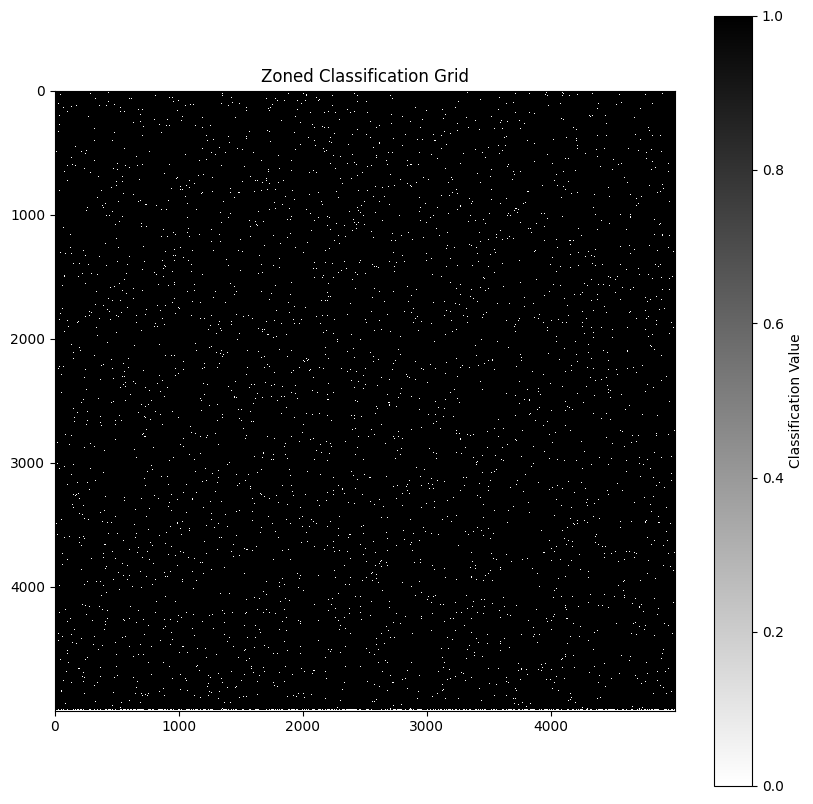

In [5]:
import numpy as np
from numba import jit, prange
import matplotlib.pyplot as plt
from Functions.post_processing import raster_to_zones
from Functions.post_processing2 import raster_to_zones_optimized

@jit(nopython=True, parallel=True)
def raster_to_zones_optimized(arr, zone_size, threshold):
    """
    Optimized parallel version of raster_to_zones using Numba
    """
    height, width = arr.shape
    new_arr = np.copy(arr)
    
    # Process zones in parallel using prange
    for i in prange(0, height - zone_size + 1, zone_size):
        for j in range(0, width - zone_size + 1, zone_size):
            classified_count = 0
            
            # Count classified pixels efficiently
            for k in range(zone_size):
                for l in range(zone_size):
                    if arr[i + k, j + l] == 1:
                        classified_count += 1
            
            # Apply threshold
            value = 1 if classified_count > (zone_size * zone_size) / threshold else 0
            
            # Set zone values
            for k in range(zone_size):
                for l in range(zone_size):
                    new_arr[i + k, j + l] = value
                    
    return new_arr

# Example usage with y_test (make sure y_test is a 5000x5000 array)
y_test = np.random.randint(0, 2, 25000000)  # Example data, 0s and 1s, flat array
labels_grid = raster_to_zones(np.array(y_test).reshape(5000, 5000), 5, 4)

# labels_grid will now contain the zoned classification
# Plotting the results
plt.figure(figsize=(10, 10))
plt.imshow(labels_grid, cmap='binary', interpolation='nearest')  # Use binary colormap for 0s and 1s
plt.title("Zoned Classification Grid")
plt.colorbar(label="Classification Value")
plt.show()

## Noise reduction

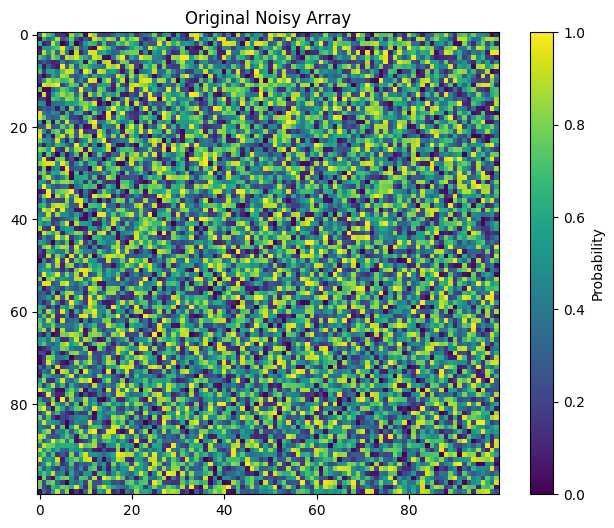

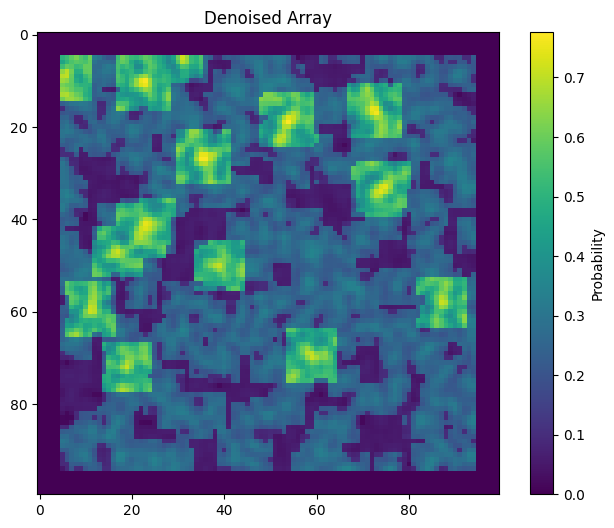

Mean squared error between original and denoised: 0.17117931883234974


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
@jit(nopython=True, parallel=True)
def custom_remove_noise(arr, radius, threshold, self_threshold):
    """Optimized noise removal using sliding window approach"""
    height, width = arr.shape
    result = np.zeros_like(arr)
    
    for i in prange(radius, height - radius):
        for j in range(radius, width - radius):
            max_val = 0
            for ki in range(-radius, radius + 1):
                for kj in range(-radius, radius + 1):
                    max_val = max(max_val, arr[i + ki, j + kj])
            
            if max_val < threshold:
                if arr[i, j] > self_threshold:
                    result[i, j] = arr[i, j] * 0.5
                else:
                    result[i, j] = arr[i, j] * 0.25
            else:
                result[i, j] = arr[i, j]
    
    return result

@jit(nopython=True)
def gaussian_kernel(size, sigma):
    """Create a Gaussian kernel for smoothing"""
    kernel = np.zeros((size, size))
    center = size // 2
    
    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            kernel[i, j] = np.exp(-(x**2 + y**2)/(2*sigma**2))
    
    return kernel / kernel.sum()  # Normalize the kernel

@jit(nopython=True)
def apply_gaussian_smooth(arr, kernel):
    """Apply Gaussian smoothing using a pre-computed kernel"""
    height, width = arr.shape
    k_size = kernel.shape[0]
    pad = k_size // 2
    result = np.zeros_like(arr)
    
    for i in range(pad, height - pad):
        for j in range(pad, width - pad):
            val = 0.0
            for ki in range(k_size):
                for kj in range(k_size):
                    val += arr[i - pad + ki, j - pad + kj] * kernel[ki, kj]
            result[i, j] = val
    
    return result

@jit(nopython=True)
def proba_noise_reduction(arr):
    """
    Removes noise from a continuous probability prediction using a combination
    of Gaussian smoothing and custom noise reduction.
    """
    # Create Gaussian kernel
    kernel = gaussian_kernel(5, 1.0)
    
    # First pass: Apply Gaussian smoothing
    smoothed = apply_gaussian_smooth(arr, kernel)
    
    # Second pass: Apply custom noise reduction
    result = custom_remove_noise(smoothed, radius=3, threshold=0.6, self_threshold=0.3)
    
    # Final pass: Additional smoothing for consistency
    final_result = custom_remove_noise(result, radius=5, threshold=0.7, self_threshold=0.4)
    
    return final_result

# Generate a sample 2D array with noise for testing
height, width = 100, 100  # Example size of the array
np.random.seed(42)
arr = np.random.random((height, width))  # Create random probability values between 0 and 1

# Introduce some noise to simulate a noisy probability array
for i in range(10):
    x, y = np.random.randint(0, height), np.random.randint(0, width)
    arr[x, y] = np.random.choice([0.0, 1.0])  # Add extreme values to introduce noise

# Plot the original noisy array
plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Probability")
plt.title("Original Noisy Array")
plt.show()

# Apply the noise reduction function
denoised = proba_noise_reduction(arr)

# Plot the denoised array
plt.figure(figsize=(8, 6))
plt.imshow(denoised, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Probability")
plt.title("Denoised Array")
plt.show()

# Optionally, you can also compare the results numerically:
# Calculate the difference between the original and denoised arrays (e.g., mean squared error)
diff = np.mean((arr - denoised) ** 2)
print(f"Mean squared error between original and denoised: {diff}")


In [ ]:
# General arr lib
import numpy as np

# Compile py code
from numba import jit, prange
from numba import prange


# Multithreading
import dask.array as da
import dask as dk
dk.config.set(scheduler='processes')

from dask.array import from_array
from dask_image.ndfilters import generic_filter as dask_generic_filter
from dask import delayed, compute
from collections import deque

from skimage.filters import gabor
from skimage.restoration import denoise_bilateral
from concurrent.futures import ThreadPoolExecutor
import math

import datetime

import numpy as np
from numpy import random, nanmax, argmax, unravel_index
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import generic_filter as scipy_generic_filter
import scipy.stats.mstats as ms
from scipy.stats import skew
import scipy.ndimage.morphology as morph
from scipy import ndimage
from PIL import Image
import scipy
import matplotlib.pyplot as plt
import re
import os
import pandas as pd
import random
import math
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.filters import gabor
from skimage.util import random_noise
from collections import deque
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from sklearn.metrics import cohen_kappa_score, accuracy_score, recall_score, confusion_matrix, precision_score
from collections import deque

from Functions import general_functions
from Functions import feature_creation2
from Functions.feature_creation2 import _create_conic_mask

C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_17208\882552223.py:29: DeprecationWarning: Please import `generic_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import generic_filter


## Noise reduction 

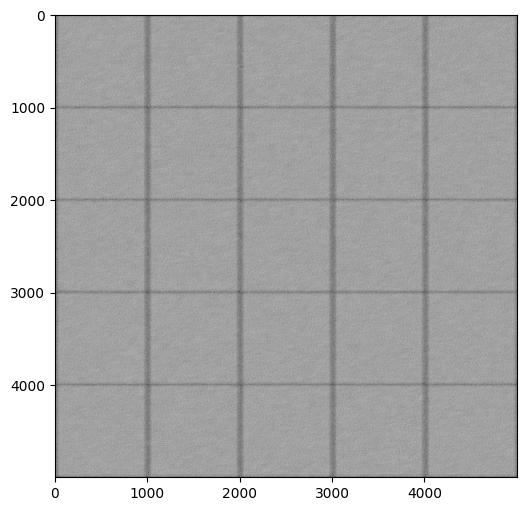

In [11]:
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
from dask.delayed import delayed
from numba import jit, prange
from skimage.restoration import denoise_bilateral
from dask import compute

# Convert Dask arrays to NumPy arrays before applying Numba's JIT
def to_numpy(arr):
    """
    Convert a Dask array to a NumPy array for Numba compatibility.
    """
    return arr.compute() if isinstance(arr, da.Array) else arr

@jit(nopython=True, parallel=True)
def raster_to_zones_optimized(arr, zone_size, threshold):
    """
    Optimized parallel version of raster_to_zones using Numba
    """
    arr = to_numpy(arr)  # Convert Dask to NumPy before using Numba
    
    height, width = arr.shape
    new_arr = np.copy(arr)
    
    # Process zones in parallel using prange
    for i in prange(0, height - zone_size + 1, zone_size):
        for j in range(0, width - zone_size + 1, zone_size):
            classified_count = 0
            
            # Count classified pixels efficiently
            for k in range(zone_size):
                for l in range(zone_size):
                    if arr[i + k, j + l] == 1:
                        classified_count += 1
            
            # Apply threshold
            value = 1 if classified_count > (zone_size * zone_size) / threshold else 0
            
            # Set zone values
            for k in range(zone_size):
                for l in range(zone_size):
                    new_arr[i + k, j + l] = value
                    
    return new_arr

def custom_remove_noise_optimized(arr, radius, threshold, self_threshold):
    """
    Optimized noise removal with parallel processing using Dask.
    """
    # Convert to Dask array if needed (without chunk_size adjustments)
    if isinstance(arr, np.ndarray):
        arr = da.from_array(arr)

    radius = 10  # Original integer value
    # Make it a tuple or list so you can index into it
    radius = (radius,)  # Convert to tuple

    # Now you can safely access radius[0]
    max_arr = da.map_overlap(
        np.max,
        arr,
        depth=radius[0],  # Use radius[0] since it's now a tuple
        boundary='reflect',
        dtype=arr.dtype
    )

    # Apply thresholding to adjust the array based on the max array
    result = da.where(
        max_arr < threshold,
        da.where(arr > self_threshold, arr * 0.5, arr * 0.25),
        arr
    )

    # Return the lazily evaluated Dask array (do not compute here)
    return result

def proba_noise_reduction(arr):
    """
    Removes noise from a continuous probability prediction using Dask.
    """
    # Convert the array into a Dask array with optimal chunk size
    d = da.from_array(arr, chunks=(1000, 1000))  # Adjust chunk size based on your hardware
    
    # Apply denoise_bilateral function across the Dask array using map_blocks
    denoised = d.map_blocks(denoise_bilateral, dtype=d.dtype, sigma_spatial=15)

    # Apply custom noise removal function
    result = custom_remove_noise_optimized(denoised, 10, 0.7, 0.4)

    # Return the result (Dask array)
    return result

# Example to test:
arr_example = np.random.random((5000, 5000))  # Example input array

# Apply noise reduction
denoised_arr = proba_noise_reduction(arr_example)

# Compute the result and visualize
denoised_result = denoised_arr.compute()

# Plot the denoised result
plt.figure(figsize=(8, 6))
plt.imshow(denoised_result, cmap='gray')
plt.show()


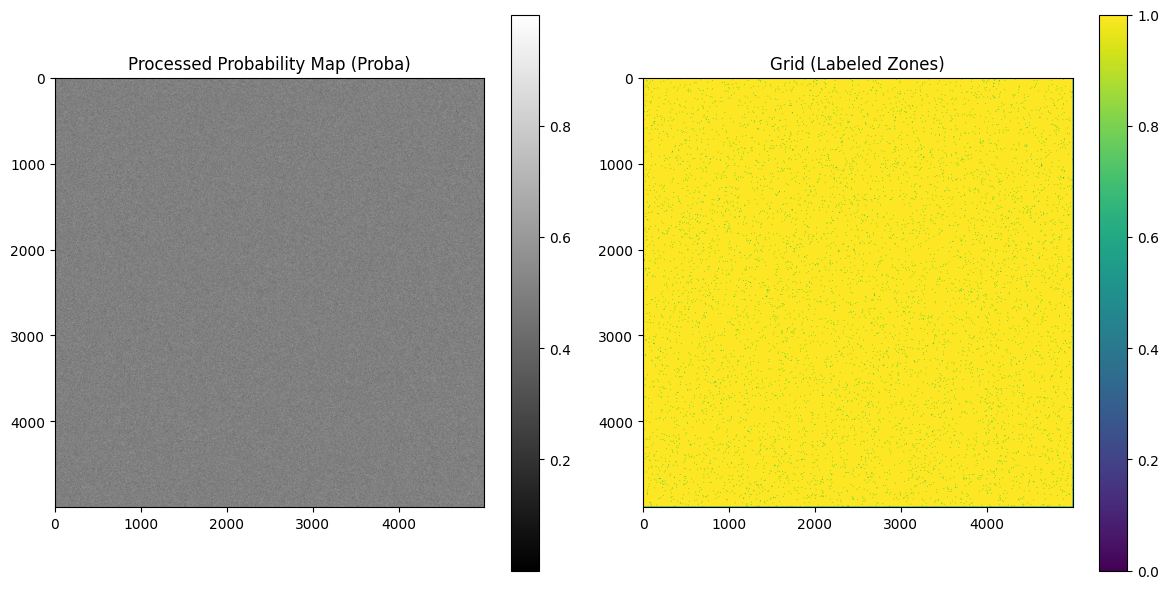

In [19]:
import numpy as np
import rasterio
from skimage.morphology import closing, opening, disk
from skimage.measure import label
from scipy.ndimage import label as ndi_label

import numpy as np
from scipy.ndimage import label as ndi_label
from skimage.morphology import closing, opening, disk

# Threshold the image
def threshold_image(arr, lower_threshold, upper_threshold):
    """
    Apply a threshold to the image to segment ditch lines or streamlines.
    """
    binary_image = (arr >= lower_threshold) & (arr <= upper_threshold)
    return binary_image.astype(np.uint8)

# Apply morphology (closing and opening)
def apply_morphology(binary_image):
    """
    Apply morphological operations to refine detected lines.
    """
    closed = closing(binary_image, disk(3))  # Dilation followed by erosion
    opened = opening(closed, disk(3))  # Optional: remove small noise
    return opened

# Label the lines (connected components)
def label_lines(binary_image):
    """
    Label connected components (lines) in the binary image.
    """
    labeled_image, num_features = ndi_label(binary_image)
    return labeled_image, num_features

# Post-process the probability map
def proba_post_process_optimized(proba, mask_radius, threshold):
    """
    This function processes the predicted probabilities (proba) and returns the processed output.
    """
    # Step 1: Threshold the probabilities (e.g., binary classification)
    binary_image = threshold_image(proba, 0.5, 1.0)  # Threshold based on your criteria

    # Step 2: Apply morphological operations to refine predictions
    refined_image = apply_morphology(binary_image)

    # Step 3: Label the lines
    labeled_image, num_features = label_lines(refined_image)

    # Step 4: Return the processed result
    return labeled_image


# Convert `y_test` to zones (mock-up, assuming zone processing is required)
def raster_to_zones(arr, zoneSize, threshold):
    """
    Converts binary pixel labels to zones with a specified zone size and threshold.
    """
    new_arr = arr.copy()
    for i in range(0, len(arr), zoneSize):
        for j in range(0, len(arr[i]), zoneSize):
            numberOfClassified = 0
            if i < len(arr) - zoneSize and j < len(arr[i]) - zoneSize:
                for k in range(zoneSize):
                    for l in range(zoneSize):
                        if arr[i + k][j + l] == 1:
                            numberOfClassified += 1
                if numberOfClassified > (zoneSize**2)/threshold:
                    for k in range(zoneSize):
                        for l in range(zoneSize):
                            new_arr[i + k][j + l] = 1
                else:
                    for k in range(zoneSize):
                        for l in range(zoneSize):
                            new_arr[i + k][j + l] = 0
    return new_arr

# Assuming clf.predict_proba(X_test) returns probabilities of shape (5000, 5000)
proba = np.random.random((5000, 5000)) 

# Post-processing (apply your custom functions here)
proba_post_process = proba_post_process_optimized(proba, 5, 0.4)

# Assuming y_test is also a 5000x5000 array for zone labeling
grid = raster_to_zones(np.array(y_test).reshape(5000, 5000), 5, 4)

# Plot the processed probability map (proba) and the labeled grid
plt.figure(figsize=(12, 6))

# Plot proba
plt.subplot(1, 2, 1)
plt.imshow(proba, cmap='gray')
plt.title('Processed Probability Map (Proba)')
plt.colorbar()

# Plot grid (zone labels)
plt.subplot(1, 2, 2)
plt.imshow(grid, cmap='viridis')
plt.title('Grid (Labeled Zones)')
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from numba import njit, prange
from concurrent.futures import ProcessPoolExecutor

@njit(parallel=True)
def conic_post_processing(arr, masks, threshold):
    """Parallel conic post-processing for sparse data."""
    height, width = arr.shape
    result = arr.copy()
    
    for i in prange(masks[0].shape[0] // 2, height - masks[0].shape[0] // 2):
        for j in range(masks[0].shape[0] // 2, width - masks[0].shape[0] // 2):
            if arr[i, j] < 0.5:
                probs = proba_mean_from_masks(arr, i, j, masks)
                max_val = 0
                
                for k in range(0, 8, 2):
                    if probs[k] > threshold and probs[k + 4] > threshold:
                        val = max(probs[k], probs[k + 4])
                        max_val = max(max_val, val)
                
                if max_val > 0:
                    # Adjust for rare data (1-2% labeled)
                    if max_val < 0.4:
                        max_val *= 1.6
                    elif max_val < 0.8:
                        max_val *= 1.2
                    result[i, j] = max_val
    
    return result

@njit
def get_cluster(arr, start_point):
    """Extract connected clusters of 1s."""
    height, width = arr.shape
    cluster = []
    stack = [start_point]
    visited = set([start_point])
    
    while stack:
        x, y = stack.pop()
        cluster.append((x, y))
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if (0 <= nx < height and 0 <= ny < width and 
                arr[nx, ny] == 1 and (nx, ny) not in visited):
                stack.append((nx, ny))
                visited.add((nx, ny))
    
    return cluster

def process_chunk(chunk_data):
    """Process a chunk of the image and remove small clusters."""
    chunk, min_size = chunk_data
    result = chunk.copy()
    visited = set()

    for i in range(chunk.shape[0]):
        for j in range(chunk.shape[1]):
            if chunk[i, j] == 1 and (i, j) not in visited:
                cluster = get_cluster(chunk, (i, j))
                if len(cluster) < min_size:
                    for x, y in cluster:
                        result[x, y] = 0
                visited.update(cluster)

    return result

def parallel_process_image(arr, zone_size=5, threshold=0.3, min_cluster_size_fraction=0.05):
    """Parallel processing pipeline for 30% sampled data."""
    def adjust_parameters(original_zone_size, original_threshold, sampling_fraction=0.30):
        adjusted_zone_size = max(2, int(original_zone_size * np.sqrt(sampling_fraction)))
        adjusted_threshold = original_threshold * sampling_fraction
        return adjusted_zone_size, adjusted_threshold
    
    adjusted_zone_size, adjusted_threshold = adjust_parameters(zone_size, threshold)
    
    radius = max(4, int(8 * np.sqrt(0.30)))  
    masks = [create_conic_mask(radius, i) for i in range(8)]
    
    denoised = proba_noise_reduction(arr)
    cleaned = custom_remove_noise(denoised, radius=max(3, int(10 * np.sqrt(0.30))), threshold=0.7, self_threshold=0.4)
    
    processed = conic_post_processing(
        conic_post_processing(cleaned, masks, 0.35 * np.sqrt(0.30)), 
        masks, 
        0.3 * np.sqrt(0.30)
    )
    
    zones = raster_to_zones_optimized(processed, adjusted_threshold)
    
    sampled_chunk_size = max(100, int(1000 * 0.30))  
    num_chunks = max(1, zones.shape[0] // sampled_chunk_size)
    chunk_size = zones.shape[0] // num_chunks
    
    min_size = max(1, int(chunk_size * min_cluster_size_fraction * np.sqrt(0.30)))
    
    chunks = [(zones[i:i + chunk_size], min_size) 
              for i in range(0, zones.shape[0], chunk_size)]
    
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_chunk, chunks))
    
    return np.vstack(results)

import matplotlib.pyplot as plt

def visualize_results(original, processed, clusters, title="Processing Visualization"):
    """
    Visualizes the original, processed, and clustered images side by side.

    Args:
        original (numpy array): The original input image.
        processed (numpy array): The image after conic post-processing.
        clusters (numpy array): The final clustered image.
        title (str): Title of the visualization.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original Image
    axes[0].imshow(original, cmap="gray", interpolation="none")
    axes[0].set_title("Original Data (30% Sampled)")
    axes[0].axis("off")

    # Processed Image (After Conic Processing)
    axes[1].imshow(processed, cmap="gray", interpolation="none")
    axes[1].set_title("Processed (Conic Post-Processing)")
    axes[1].axis("off")

    # Clustered Output
    axes[2].imshow(clusters, cmap="gray", interpolation="none")
    axes[2].set_title("Final Clusters (Noise Removed)")
    axes[2].axis("off")

    fig.suptitle(title, fontsize=16)
    plt.show()
